## Detection of correlated input to FS with and without gap junctions.

There are two population units for FS neurons, population unit 1 and population unit 2. In addition there are FS units without a population unit (0). The two population units receive cortical and thalamic input with 2Hz frequency. The correlation of population unit 1 is increased between 1 and 1.1 seconds for the cortical input, and between 2 and 2.1 seconds for the thalamic input.

In [1]:
import os
import numpy as np

os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example."

network_path = os.path.join("networks", "FS_correlation_detection")

In [ ]:
from snudda import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=12345)
si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=50, num_LTS=0, num_ChIN=0)

# The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
# First test, we place units on top of each other -- set num_neurons to 8
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 0]),
                               probability_function="(d < 300e-6)*1", num_neurons=20)
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0,0,0]),
                               probability_function="(d < 300e-6) * 1", num_neurons=20)
 
si.write_json()

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

### Plotting the network
Plotting the network to verify that the population units are placed the way we expect.

In [ ]:
from snudda.plotting import PlotNetwork
pos_file = os.path.join(network_path, "network-neuron-positions.hdf5")

pn = PlotNetwork(pos_file)
pn.plot_populations()

# The commented code below also plots the network, but with the option to plot more detail of the neurons:
# pn = PlotNetwork(network_path)
# pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False, colour_population_unit=True)

pn.close()  # Close the hdf5 file so others can use it (or better shut down kernel after)

### Check if ipyparallel running
For larger networks it is useful to run network creation in parallel.

In [ ]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc, verbose=False)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc, verbose=False)
sp.prune()

### Generate input

Next we generate the input according to specifications in [FS-input-correlation-detection-1.json](FS-input-correlation-detection-1.json)

In [ ]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=os.path.join("FS-input-correlation-detection-1.json"),
                 time=1.5,
                 rc=rc, verbose=False)
si.generate()

### Plot the input to verify it looks reasonable

In [ ]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

Input to FS population unit 1. Here we have a correlation increase in cortical input between 1 and 1.1 seconds, and in thalamic input between 2 and 2.1 seconds.

In [ ]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS population unit 2 receives elevated input but no change in correlation.

In [ ]:
spi.plot_input_population_unit(population_unit_id=2, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS neurons without population unit receive the same low background input constantly.

In [ ]:
spi.plot_input_population_unit(population_unit_id=0, num_neurons=2, neuron_type="FS", fig_size=(15,5))

### Compile neuron modules

In [ ]:
!nrnivmodl ../../../../BasalGangliaData/data/neurons/mechanisms

### Run the simulation

In [ ]:
!mpiexec -n 3 snudda simulate networks/FS_correlation_detection --time 2

In [ ]:
!mpiexec -n 3 snudda simulate networks/FS_correlation_detection --time 2 --disableGJ --outputFile networks/FS_correlation_detection/simulation/output-no-GJ.hdf5

In [ ]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc1 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output.hdf5"))
pcc1.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr.png"))

In [ ]:
pcc2 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output-no-GJ.hdf5"))
pcc2.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr-no-gj.png"))

### Plotting

We want to plot the binned frequency for the different populations as a function of time, to see if there is a difference in output frequency during 1-1.1 seconds and 2-2.1 seconds. 

Loading 20 neurons with 854 synapses and 716 gap junctions
Loading networks/FS_correlation_detection/simulation/output.hdf5
Saving figure to networks/FS_correlation_detection/figures/spike-raster-gj.pdf


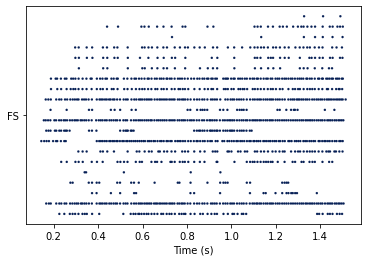

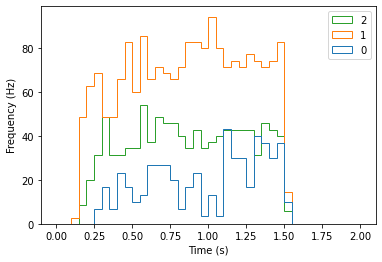

--Return--
None
> /home/hjorth/HBP/Snudda/snudda/plotting/plot_spike_raster_v2.py(270)plot_spike_histogram()
    268 
    269         import pdb
--> 270         pdb.set_trace()
    271 
    272     def plot_spike_raster(self, type_order=None, skip_time=0, end_time=None, fig_size=None):

ipdb> c


In [2]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file = os.path.join(network_path, "simulation", "output.hdf5")
fig_file = os.path.join(network_path, "figures", "spike-raster-gj.pdf")
spr = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file, figure_path=fig_file)
spr.plot_spike_raster()
spr.plot_spike_histogram()

Loading 20 neurons with 854 synapses and 716 gap junctions
Loading networks/FS_correlation_detection/simulation/output-no-GJ.hdf5
Saving figure to networks/FS_correlation_detection/figures/spike-raster-no-gj.pdf


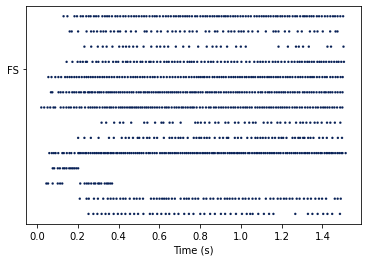

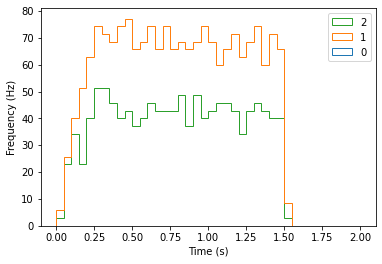

--Return--
None
> /home/hjorth/HBP/Snudda/snudda/plotting/plot_spike_raster_v2.py(270)plot_spike_histogram()
    268 
    269     def plot_spike_raster(self, type_order=None, skip_time=0, end_time=None, fig_size=None):
--> 270 
    271         self.make_figures_directory()
    272 



In [ ]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file_no_gj = os.path.join(network_path, "simulation", "output-no-GJ.hdf5")
fig_file_no_gj = os.path.join(network_path, "figures", "spike-raster-no-gj.pdf")
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file_no_gj, figure_path=fig_file_no_gj)
spr2.plot_spike_raster()
spr2.plot_spike_histogram()